In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

loading dataset

In [2]:
data = pd.read_csv('titanic_train.csv')
print(data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


# EDA

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [4]:
print(data.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


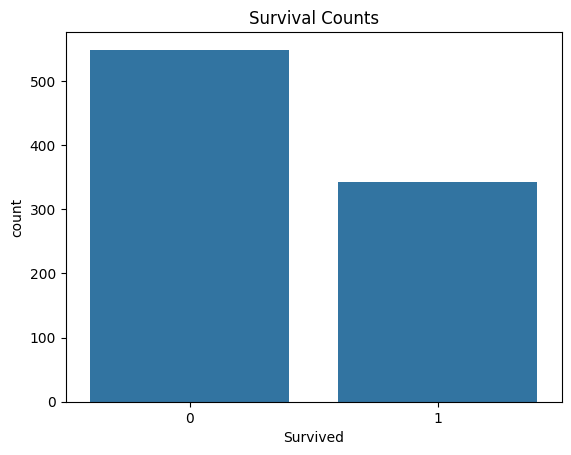

In [5]:
sns.countplot(x='Survived', data=data)
plt.title('Survival Counts')
plt.show()

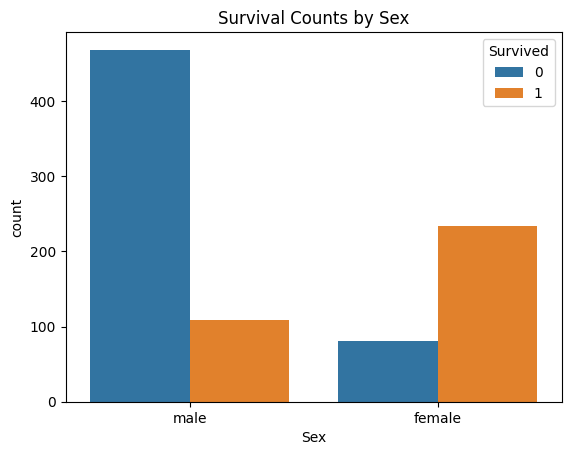

In [6]:
sns.countplot(x='Sex', hue='Survived', data=data)
plt.title('Survival Counts by Sex')
plt.show()

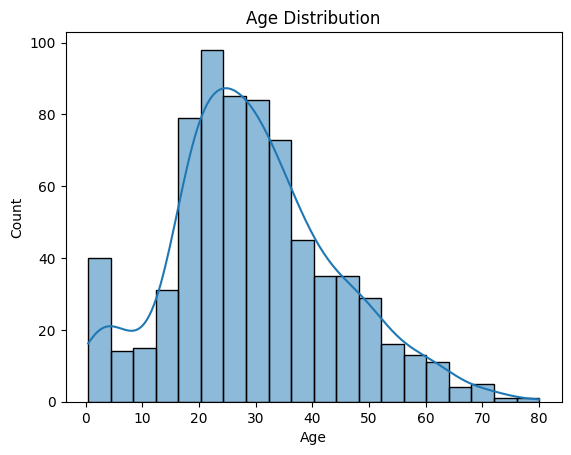

In [7]:
sns.histplot(data['Age'].dropna(), kde=True)
plt.title('Age Distribution')
plt.show()

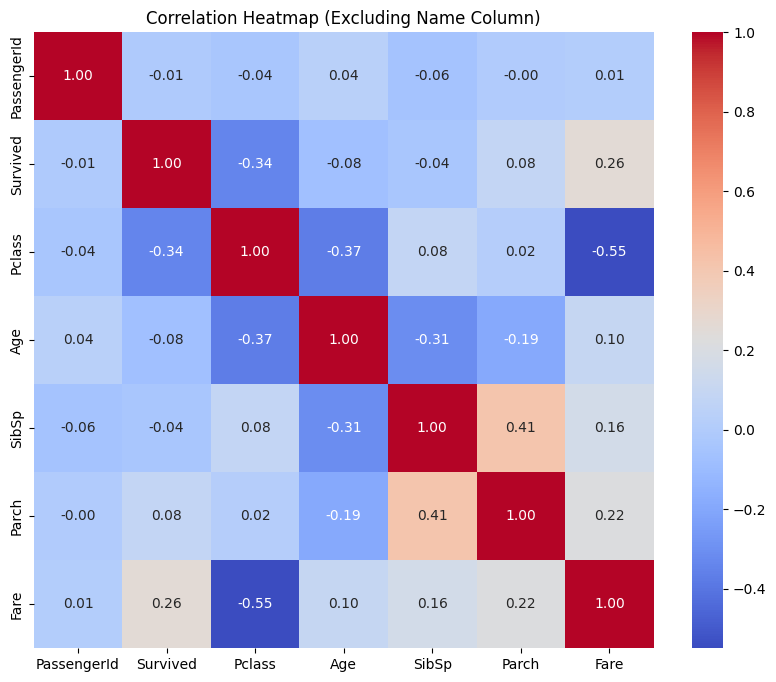

In [10]:
data_for_corr = data.drop(['Name'], axis=1)
numeric_columns = data_for_corr.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Excluding Name Column)')
plt.show()

# Preprocessing

handeling missing values

In [13]:
print("Missing values before imputation:")
print(data.isnull().sum())

age_imputer = SimpleImputer(strategy='median')
data['Age'] = age_imputer.fit_transform(data[['Age']])

print("Data type of 'Embarked':", data['Embarked'].dtype)
print("Unique values in 'Embarked':", data['Embarked'].unique())

data['Embarked'].replace('', np.nan, inplace=True)
data['Embarked'].replace(' ', np.nan, inplace=True)

data['Embarked'] = data['Embarked'].astype(str)

most_frequent_embarked = data['Embarked'].mode()[0]
data['Embarked'].fillna(most_frequent_embarked, inplace=True)

data.drop('Cabin', axis=1, inplace=True)

print("Missing values after imputation:")
print(data.isnull().sum())

Missing values before imputation:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Data type of 'Embarked': object
Unique values in 'Embarked': ['S' 'C' 'Q' nan]
Missing values after imputation:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


encoding categorical var

In [14]:
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])  # male 1, female 0

data = pd.get_dummies(data, columns=['Embarked', 'Pclass'], drop_first=True)

data.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

feature selection

In [15]:
X = data.drop('Survived', axis=1)
y = data['Survived']



Selected Features: Index(['Sex', 'Age', 'Parch', 'Fare', 'Embarked_S', 'Embarked_nan', 'Pclass_2',
       'Pclass_3'],
      dtype='object')


In [16]:
selector = SelectKBest(score_func=chi2, k=4)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['Sex', 'Age', 'Fare', 'Pclass_3'], dtype='object')


outliers

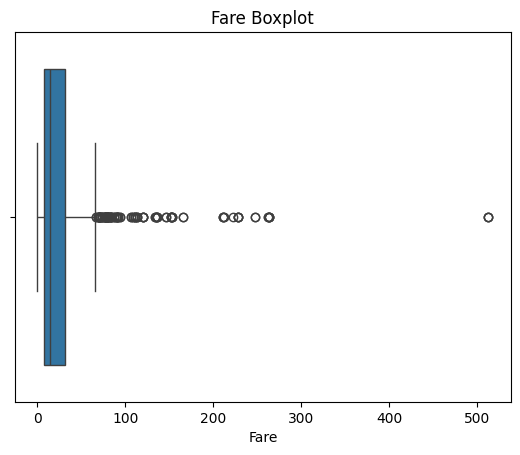

In [17]:
sns.boxplot(x=data['Fare'])
plt.title('Fare Boxplot')
plt.show()

In [18]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

data = remove_outliers(data, 'Fare')

dataset splitting

In [19]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature scaling

In [20]:
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']

scaler = StandardScaler()

X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Model building

logistic regression

In [21]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
acc_logreg = accuracy_score(y_test, y_pred_logreg)
print(f'Logistic Regression Accuracy: {acc_logreg:.4f}')

Logistic Regression Accuracy: 0.7613


decision tree

In [22]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {acc_dt:.4f}')

Decision Tree Accuracy: 0.7484


random forest

In [23]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {acc_rf:.4f}')

Random Forest Accuracy: 0.7677


svm

In [24]:
svc = SVC(random_state=42)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)
print(f'SVM Accuracy: {acc_svc:.4f}')

SVM Accuracy: 0.7871


knn

In [25]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN Accuracy: {acc_knn:.4f}')

KNN Accuracy: 0.7226


# Model Comparing

In [26]:
model_accuracy = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'KNN'],
    'Accuracy': [acc_logreg, acc_dt, acc_rf, acc_svc, acc_knn]
})
print(model_accuracy)

                 Model  Accuracy
0  Logistic Regression  0.761290
1        Decision Tree  0.748387
2        Random Forest  0.767742
3                  SVM  0.787097
4                  KNN  0.722581


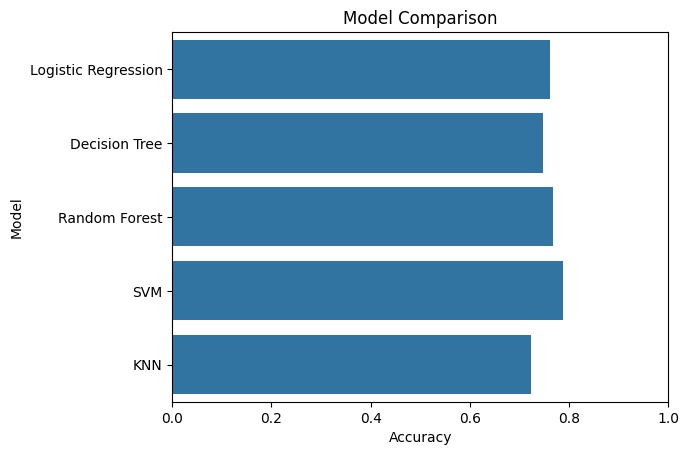

In [27]:
sns.barplot(x='Accuracy', y='Model', data=model_accuracy)
plt.title('Model Comparison')
plt.xlim(0,1)
plt.show()

In [28]:
print("Classification Report for SVM:")
print(classification_report(y_test, y_pred_svc))

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.79      0.88      0.84        95
           1       0.78      0.63      0.70        60

    accuracy                           0.79       155
   macro avg       0.78      0.76      0.77       155
weighted avg       0.79      0.79      0.78       155



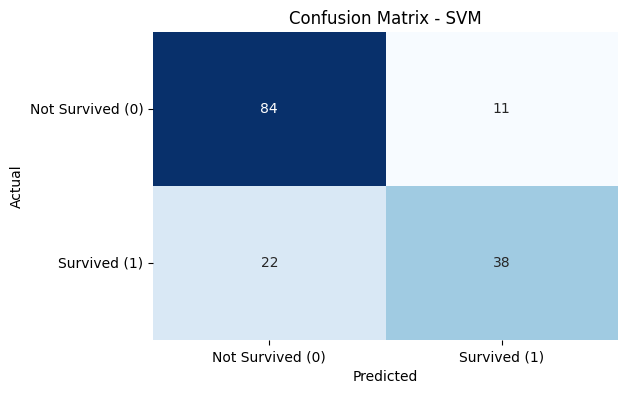

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred_svc)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5,1.5], ['Not Survived (0)', 'Survived (1)'])
plt.yticks([0.5,1.5], ['Not Survived (0)', 'Survived (1)'], rotation=0)
plt.show()

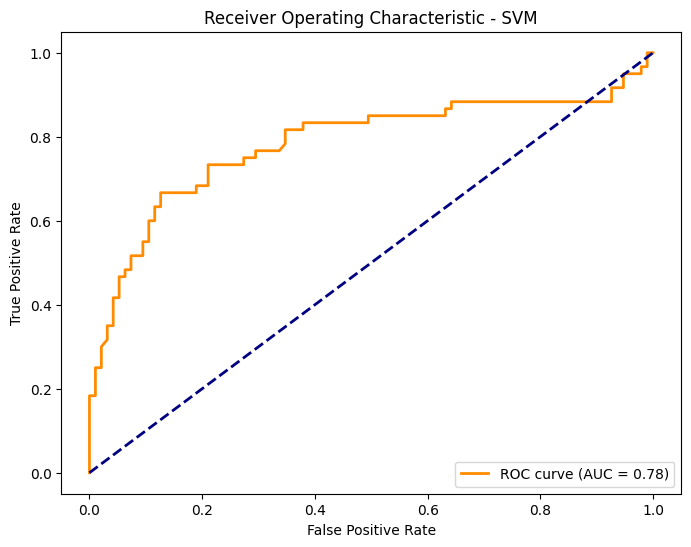

In [30]:
from sklearn.metrics import roc_curve, auc

y_scores = svc.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SVM')
plt.legend(loc="lower right")
plt.show()

# Hyperparameter Tuning

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

In [32]:
svm = SVC(probability=True, random_state=42)

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [33]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=2)

In [34]:
print("Best Parameters from Grid Search:")
print(grid_search.best_params_)

best_svm = grid_search.best_estimator_

Best Parameters from Grid Search:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [35]:
svm_best = SVC(C=1, gamma='scale', kernel='rbf', probability=True)
svm_best.fit(X_train, y_train)

SVC(C=1, probability=True)

In [36]:
y_pred_best = svm_best.predict(X_test)

In [38]:
from sklearn.metrics import roc_auc_score
classification_report_best = classification_report(y_test, y_pred_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
accuracy_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, svm_best.predict_proba(X_test)[:, 1])

print("Classification Report for Optimized SVM:\n", classification_report_best)
print("Confusion Matrix for Optimized SVM:\n", conf_matrix_best)
print("Accuracy for Optimized SVM:", accuracy_best)
print("AUC for Optimized SVM:", roc_auc_best)

Classification Report for Optimized SVM:
               precision    recall  f1-score   support

           0       0.79      0.88      0.84        95
           1       0.78      0.63      0.70        60

    accuracy                           0.79       155
   macro avg       0.78      0.76      0.77       155
weighted avg       0.79      0.79      0.78       155

Confusion Matrix for Optimized SVM:
 [[84 11]
 [22 38]]
Accuracy for Optimized SVM: 0.7870967741935484
AUC for Optimized SVM: 0.7833333333333333


# Model save

In [39]:
import pickle

model_filename = 'optimized_svm_titanic_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(svm_best, file)

print(f"Model saved to {model_filename}")

Model saved to optimized_svm_titanic_model.pkl


In [40]:
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

y_pred_loaded = loaded_model.predict(X_test)

loaded_model_accuracy = accuracy_score(y_test, y_pred_loaded)
print(f"Loaded Model Accuracy: {loaded_model_accuracy}")

Loaded Model Accuracy: 0.7870967741935484
